In [330]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import random
from datetime import datetime
from datetime import date
from datetime import time
import math
import statistics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import plot_importance
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score,roc_auc_score,auc,roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.ensemble import IsolationForest
import lightgbm as lgb

In [331]:
from sklearn import cross_validation

# Data input

In [332]:
train=pd.read_csv('uconn_comp_2018_train.csv')
test=pd.read_csv('uconn_comp_2018_test.csv')

In [333]:
all_data = pd.concat((train, test)).reset_index(drop=True)
print("size：",all_data.shape)

size： (30000, 25)


# Explore missing data

In [334]:
col=['gender','marital_status','high_education_ind','address_change_ind',
     'living_status','claim_day_of_week','accident_site','witness_present_ind',
     'channel','policy_report_filed_ind','vehicle_category','vehicle_color'
    ]
for i in col:
    l=list(set(all_data[i]))
    print('unique value of col:%s'%i,l)

unique value of col:gender ['M', 'F']
unique value of col:marital_status [0.0, 1.0, nan, nan, nan, nan, nan, nan, nan]
unique value of col:high_education_ind [0, 1]
unique value of col:address_change_ind [0, 1]
unique value of col:living_status ['Rent', 'Own']
unique value of col:claim_day_of_week ['Tuesday', 'Friday', 'Sunday', 'Monday', 'Thursday', 'Saturday', 'Wednesday']
unique value of col:accident_site ['Local', 'Highway', 'Parking Lot']
unique value of col:witness_present_ind [0.0, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [335]:
# fill missing value case by case
## fill marital_status with random choice 
all_data['m']=list(np.random.choice([0, 1], size=(len(all_data),), p=[1-np.mean(all_data['marital_status']), np.mean(all_data['marital_status'])]))
all_data['marital_status'].fillna(all_data['m'],inplace=True)
all_data.drop('m',axis=1,inplace=True)

## fill witness_present_ind with random choice
all_data['w']=list(np.random.choice([0,1],size=(len(all_data),),p=[1-np.mean(all_data['witness_present_ind']),np.mean(all_data['witness_present_ind'])]))
all_data['witness_present_ind'].fillna(all_data['w'],inplace=True)
all_data.drop('w',axis=1,inplace=True)

## drop fraud==-1
all_data.loc[all_data['fraud']==-1,'fraud'] = 1

## fill claim_est_payout with mean
all_data['claim_est_payout'].fillna(np.mean(all_data['claim_est_payout']),inplace=True)

## fill age_of_vehicle with median since the distribution is left skewed
all_data['age_of_vehicle'].fillna(statistics.median(all_data['age_of_vehicle']),inplace=True)

# Convert outlier

In [336]:
# convert outliers of age_of_drivers >=100
all_data.loc[all_data['age_of_driver']>100,'age_of_driver']=statistics.median(all_data['age_of_driver'])

# convert outliers of annual_income (<0)
# all_data.loc[all_data['annual_income']<0,'annual_income']=0.01


# Convert zipcode to geocoding info

In [337]:
zip2loc = pd.read_csv("zip2loc.csv")
all_data = pd.merge(all_data, zip2loc[["Zipcode", "Lat", "Long", "State",'City','EstimatedPopulation','TotalWages','TaxReturnsFiled']], left_on = 'zip_code', right_on = "Zipcode", how = 'left')
all_data = all_data.drop(["zip_code"], axis = 1)
all_data = all_data.rename(columns = {"Lat" : "latitude", "Long" : "longitude", "State" : "state"})
all_data['state']=pd.Categorical(all_data['state']).codes
all_data['City']=pd.Categorical(all_data['City']).codes

# filling missing zipcode with random choice of 5 cluster center
from sklearn.cluster import KMeans
t=all_data[(all_data['fraud'].isnull().values==False)& (all_data['Zipcode'].isnull().values==False)][['latitude','longitude']]
kmeans = KMeans(n_clusters=5, random_state=0).fit(t)
center=kmeans.cluster_centers_

mask=all_data['Zipcode'].isnull().values==True
all_data.loc[mask,'latitude']=all_data['latitude'].apply(lambda row: random.sample(center[:,0].tolist(),1)[0])
all_data.loc[mask,'longitude']=all_data['longitude'].apply(lambda row: random.sample(center[:,1].tolist(),1)[0])
all_data['latitude']=all_data['latitude'].apply(pd.to_numeric, errors='coerce')
all_data['longitude']=all_data['longitude'].apply(pd.to_numeric, errors='coerce')

# feature engineering

In [338]:
from sklearn.cluster import KMeans
t=all_data[(all_data['fraud'].isnull().values==False)&(all_data['past_num_of_claims'].isnull().values==False)][['past_num_of_claims']]
kmeans = KMeans(n_clusters=5, random_state=0).fit(t)
center=kmeans.cluster_centers_
mask=all_data['Cluster'].isnull().values==True
all_data.loc[mask,'Cluster']=all_data['Cluster'].apply(lambda row: random.sample(center[:,0].tolist(),1)[0])
all_data['Cluster']=all_data['Cluster'].apply(pd.to_numeric, errors='coerce')

KeyError: 'Cluster'

In [339]:
# change claim_date from date type to month, day, year
all_data['claim_date']=pd.to_datetime(all_data['claim_date'])
all_data['month']=all_data['claim_date'].dt.month
all_data['day']=all_data['claim_date'].dt.day
all_data['year']=all_data['claim_date'].dt.year

# create age group
all_data.loc[:,'age_group'] = all_data['age_of_driver'].apply(lambda x: math.floor(x/10))
all_data['age_group'] = pd.Categorical(all_data['age_group']).codes

#create gender marriage the value correspond to the prob of fraud
m0 = (all_data['gender'] == 'M') & (all_data['marital_status'] == 0)
m1 = (all_data['gender'] == 'M') & (all_data['marital_status'] == 1)
f0 = (all_data['gender'] == 'F') & (all_data['marital_status'] == 0)
f1 = (all_data['gender'] == 'F') & (all_data['marital_status'] == 1)
all_data.loc[m0,'gender_marrige'] = 2
all_data.loc[m1,'gender_marrige'] = 4
all_data.loc[f0,'gender_marrige'] = 3
all_data.loc[f1,'gender_marrige'] = 5
group = all_data.groupby('gender_marrige')['fraud'].sum()/len(all_data)
group2 = all_data.groupby('marital_status')['fraud'].sum()
#all_data = all_data.drop(['gender','marital_status'], axis =1 )

#safty_rating, if safty rating > 30, low prob of fraud
all_data.loc[all_data['safty_rating']<30, 'safty_rating_new'] = 1
all_data.loc[all_data['safty_rating']>=30, 'safty_rating_new'] = 0
#all_data = all_data.drop('safty_rating', axis = 1)

#not sure price/income
all_data.loc[:,'price/income'] = all_data['vehicle_price']/all_data['annual_income']
#all_data = all_data.drop(['vehicle_price','annual_income'],axis=1)

#claim/income
all_data.loc[:,'claim/weight'] = all_data['claim_est_payout']/all_data['vehicle_weight']
#all_data = all_data.drop(['claim_est_payout','annual_income'],axis=1)
all_data.loc[:,'edu*income'] = all_data['high_education_ind']*all_data['annual_income']
all_data.loc[:,'claim/safty'] = all_data['claim_est_payout']*all_data['safty_rating']
#all_data.loc[:,'price/address'] = all_data['vehicle_price']*all_data['address_change_ind']
#claim*liab,
#all_data.loc[:,'age*liab'] = all_data['age_of_vehicle']*all_data['liab_prct']
all_data.loc[:,'claim/age'] =  all_data['past_num_of_claims']*all_data['age_of_driver']

#age/age
#all_data.loc[:,'age/age'] = all_data['age_of_vehicle']*all_data['age_of_driver']
#claim*liab,
#all_data.loc[:,'claim*liab'] = all_data['claim_est_payout']*all_data['liab_prct']
#all_data = all_data.drop(['claim_est_payout','liab_prct'],axis=1)

#claim/income/liab
#all_data.loc[:,'claim/income/liab'] = all_data['claim_est_payout']/(all_data['annual_income']*all_data['liab_prct'])
#all_data = all_data.drop(['claim_est_payout','liab_prct','annual_income'],axis=1)

#lat*long
all_data['lat*long']=all_data['latitude']*all_data['longitude']

# change categorical data to numeric data
categorical_features=['gender','living_status','claim_day_of_week','accident_site','gender_marrige','safty_rating_new',
                      'channel','vehicle_category','vehicle_color','past_num_of_claims']
for f in categorical_features:
    all_data = pd.concat([all_data, pd.get_dummies(all_data[f], prefix = f)], axis=1)
all_data = all_data.drop(categorical_features, axis = 1)

In [340]:
train = all_data[all_data['fraud'].isnull().values==False]
test = all_data[all_data['fraud'].isnull().values==True]

# reset index
train=train.reset_index()
test=test.reset_index()

train.to_csv('train_final.csv',index=False)
test.to_csv('test_final.csv',index=False)

## Modeling

In [341]:
train=pd.read_csv('train_final.csv')
test=pd.read_csv('test_final.csv')

variable_names = list(train)
do_not_use_for_training = ['index','claim_date',
                         'claim_number',
                         'fraud',
                         'Zipcode',
                         'state',
                         'City',
                         'EstimatedPopulation',
                         'TotalWages',
                         'TaxReturnsFiled',
                          'claim/income/liab']

feature_names = [f for f in variable_names if f not in do_not_use_for_training]

X_train = train[feature_names]
Y_train = train['fraud']
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)

X_test = test[feature_names]
X_test_std=sc.transform(X_test)

# xgboost

In [12]:
# choose best n_estimator
param_test = {'n_estimators':range(100,600,50)}
clf = GridSearchCV(estimator = xgb.XGBClassifier(min_child_weight=1,learning_rate =0.1,max_depth=8,gamma=0,subsample=0.8, colsample_bytree=0.8,
                                                 scale_pos_weight=1,objective= 'binary:logistic',silent=1,booster='gbtree', nthread=4, seed=27),
                   param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_xgb = clf.fit(X_train_std, Y_train)
print('Best n_estimators:', best_xgb.best_estimator_.get_params()['n_estimators'])
print('Best score:', best_xgb.best_score_)
# Best n_estimators: 100
# Best score: 0.6922050866534016

Best n_estimators: 100
Best score: 0.6922050866534016


In [13]:
# choose best max_depth
param_test = {'max_depth':range(2,10,1)}
clf = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=100,min_child_weight=1,learning_rate =0.1,gamma=0,subsample=0.8, colsample_bytree=0.8,
                                                 objective= 'binary:logistic',silent=1,booster='gbtree', nthread=4, scale_pos_weight=1,seed=27),
                   param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_xgb = clf.fit(X_train_std, Y_train)
print('Best max_depth:', best_xgb.best_estimator_.get_params()['max_depth'])
print('Best score:', best_xgb.best_score_)
# Best max_depth: 3
# Best score: 0.7220150055512138

Best max_depth: 3
Best score: 0.7220150055512138


In [14]:
# choose best min_child_weight
param_test = {'min_child_weight':range(0,6,1)}
clf = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=100,min_child_weight=1,max_depth=3,learning_rate =0.1,gamma=0,subsample=0.8, colsample_bytree=0.8,
                                                 objective= 'binary:logistic',silent=1,booster='gbtree', nthread=4, scale_pos_weight=1,seed=27),
                   param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_xgb = clf.fit(X_train_std, Y_train)
print('Best min_child_weight:', best_xgb.best_estimator_.get_params()['min_child_weight'])
print('Best score:', best_xgb.best_score_)
# Best min_child_weight: 1
# Best score: 0.7220150055512138

Best min_child_weight: 1
Best score: 0.7220150055512138


In [23]:
# choose best subsample,colsample_bytree
param_test = {'subsample':[i/100.0 for i in range(75,90,5)],
             'colsample_bytree':[i/100.0 for i in range(75,90,5)]}
clf = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=100,max_depth=3,min_child_weight=1,learning_rate =0.1,gamma=0,scale_pos_weight=1,
                                                 objective= 'binary:logistic',silent=1,booster='gbtree', nthread=4, seed=27),
                   param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_xgb = clf.fit(X_train_std, Y_train)
print('Best subsample:', best_xgb.best_estimator_.get_params()['subsample'])
print('Best colsample_bytree:', best_xgb.best_estimator_.get_params()['colsample_bytree'])
print('Best score:', best_xgb.best_score_)
# Best subsample: 0.8
# Best colsample_bytree: 0.75
# Best score: 0.7229687900615012

Best subsample: 0.8
Best colsample_bytree: 0.75
Best score: 0.7229687900615012


In [24]:
# choose best reg_alpha
param_test = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]}
clf = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=100,max_depth=3,min_child_weight=1,learning_rate =0.1,gamma=0,scale_pos_weight=1,
                                                 subsample=0.8,colsample_bytree=0.75,
                                                 objective= 'binary:logistic',silent=1,booster='gbtree', nthread=4, seed=27),
                   param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_xgb = clf.fit(X_train_std, Y_train)
print('Best reg_alpha:', best_xgb.best_estimator_.get_params()['reg_alpha'])
print('Best score:', best_xgb.best_score_)

Best reg_alpha: 0.01
Best score: 0.7237667879665539


In [25]:
# choose best learning_rate
param_test = {'learning_rate':[0, 0.001, 0.01, 0.05,0.08,0.1,0.2]}
clf = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=100,max_depth=3,min_child_weight=1,learning_rate =0.1,gamma=0,scale_pos_weight=1,
                                                 subsample=0.8,colsample_bytree=0.75,reg_alpha=0.01,
                                                 objective= 'binary:logistic',silent=1,booster='gbtree', nthread=4, seed=27),
                   param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_xgb = clf.fit(X_train_std, Y_train)
print('Best learning_rate:', best_xgb.best_estimator_.get_params()['learning_rate'])
print('Best score:', best_xgb.best_score_)

Best learning_rate: 0.1
Best score: 0.7237667879665539


In [ ]:
# without standardization, we get higher score
# Best max_depth: 3
# Best score: 0.7244080195153353

In [283]:
y_test_pred_xgb=model1.predict_proba(X_test_std)[:,1]
result=pd.DataFrame()
result['claim_number']=test['claim_number']
result['fraud']=y_test_pred_xgb.tolist()
result.to_csv('csv_to_submit.csv', index = False)

0.7115685054590113


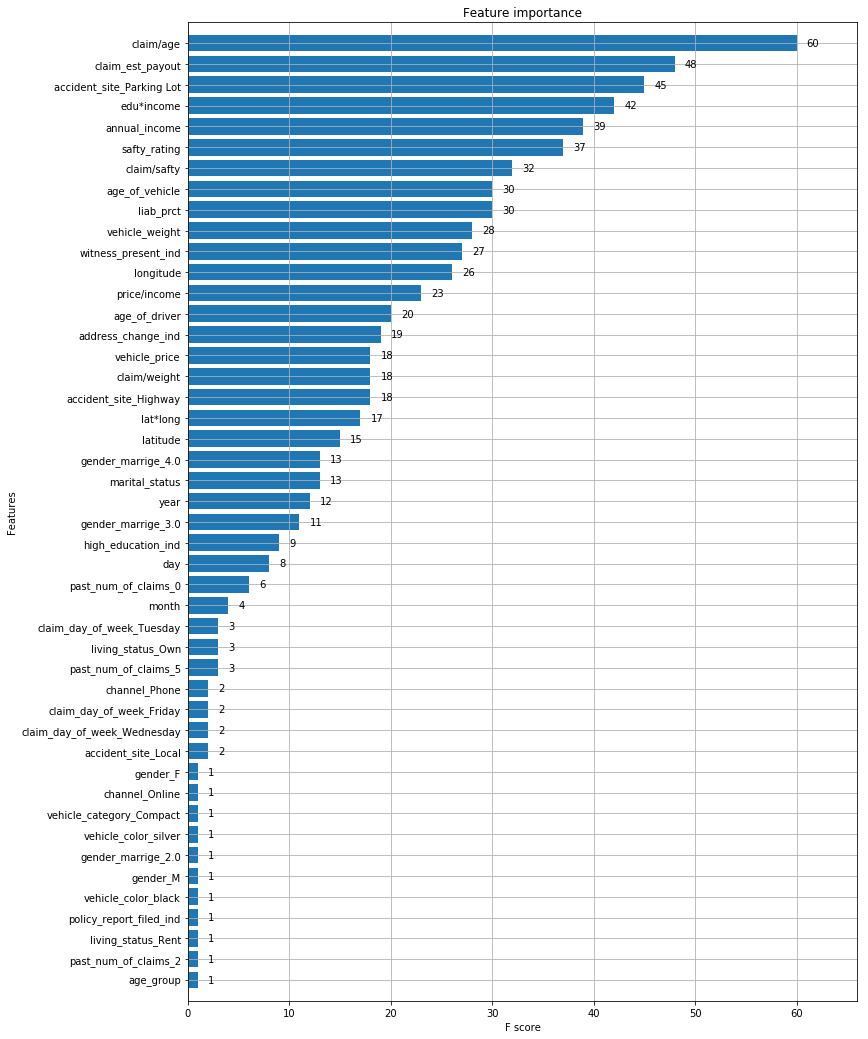

In [342]:
x_train,x_test,y_train,y_test = train_test_split(X_train, Y_train,test_size = 0.2,random_state=10)
model1 = xgb.XGBClassifier(n_estimators=100,
    learning_rate =0.1,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.75,
    objective= 'binary:logistic',
    nthread=12,
    scale_pos_weight=1,
    reg_alpha=0.01,
    seed=27)
model1.fit(x_train,y_train)
fpr,tpr,thresholds=roc_curve(y_test,model1.predict_proba(x_test)[:,1])
print(auc(fpr,tpr))
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(model1, max_num_features=100, height=0.8, ax=ax)
plt.show()

## Random Forest

In [47]:
# choose best n_estimators
param_test = {'n_estimators':[100,1000,1100]}
clf = GridSearchCV(RandomForestClassifier(min_samples_split=100,min_samples_leaf=20,max_depth=8,max_features='sqrt' 
                                          ,random_state=10),param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_rf = clf.fit(X_train_std, Y_train)
print('Best estimator:', best_rf.best_estimator_.get_params()['n_estimators'])
print('Best score:', best_rf.best_score_)
# Best estimator: 1100
# Best score: 0.7062094851616953

Best estimator: 1100
Best score: 0.7062094851616953


In [50]:
# choose best max_depth,min_samples_split
param_test = {'max_depth':range(3,14,2),
             'min_samples_split':range(50,201,20)}
clf = GridSearchCV(RandomForestClassifier(n_estimators=100,min_samples_leaf=20,max_features='sqrt',random_state=10,oob_score=True,)
                   ,param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_rf = clf.fit(X_train_std, Y_train)
print('Best max_depth:', best_rf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_rf.best_estimator_.get_params()['min_samples_split'])
print('Best score:', best_rf.best_score_)
# Best max_depth: 11
# Best min_samples_split: 70
# Best score: 0.7072273678413027

Best max_depth: 11
Best min_samples_split: 70
Best score: 0.7072273678413027


In [51]:
# choose best max_depth,min_samples_split
param_test = {'min_samples_split':range(60,100,10),
             'min_samples_leaf':range(10,60,10)}
clf = GridSearchCV(RandomForestClassifier(n_estimators=100,max_depth=11,
                                          max_features='sqrt',random_state=10,oob_score=True)
                                       ,param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_rf = clf.fit(X_train_std, Y_train)
print('Best min_samples_leaf:', best_rf.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_samples_split:', best_rf.best_estimator_.get_params()['min_samples_split'])
print('Best score:', best_rf.best_score_)
# Best min_samples_leaf: 20
# Best min_samples_split: 70
# Best score: 0.7072273678413027

Best min_samples_leaf: 20
Best min_samples_split: 70
Best score: 0.7072273678413027


In [140]:
x_train,x_test,y_train,y_test = train_test_split(X_train_std, Y_train,test_size = 0.2,random_state = 10)
model2 = RandomForestClassifier(n_estimators=100,
    max_depth=11,
    max_features='sqrt',
    min_samples_split=70,
    min_samples_leaf=20,
    oob_score=True,
    random_state=10)
model2.fit(x_train,y_train)
fpr,tpr,thresholds=roc_curve(y_test,model2.predict_proba(x_test)[:,1])
print(auc(fpr,tpr))

0.9990928094822067


In [61]:
y_test_pred_rf=best_rf.predict_proba(X_test_std)[:,1]
result=pd.DataFrame()
result['claim_number']=test['claim_number']
result['fraud']=y_test_pred_xgb.tolist()
result.to_csv('csv_to_submit.csv', index = False)

## GradientBoosting

In [65]:
# choose best n_estimators
parameters = {"n_estimators":range(100,600,50)}

clf= GridSearchCV(GradientBoostingClassifier(learning_rate=0.1,min_samples_split=300,
                                            min_samples_leaf=20,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                                      parameters, cv=5, n_jobs=4,scoring='roc_auc',iid=False)

best_gbc=clf.fit(X_train_std,Y_train)
print('Best n_estimators:', best_gbc.best_estimator_.get_params()['n_estimators'])
print('Best score:', best_gbc.best_score_)
# Best n_estimators: 100
# Best score: 0.7076347077655666

Best n_estimators: 100
Best score: 0.7076347077655666


In [70]:
# choose best min_samples_split, min_sample_leaf
parameters = {'min_samples_split':range(100,600,100),
             'min_samples_leaf':range(20,100,10)}

clf= GridSearchCV(GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,
                                            max_features='sqrt',subsample=0.8,random_state=10), 
                                      parameters, cv=5, n_jobs=4,scoring='roc_auc',iid=False)

best_gbc=clf.fit(X_train_std,Y_train)
print('Best min_samples_split:', best_gbc.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_gbc.best_estimator_.get_params()['min_samples_leaf'])
print('Best score:', best_gbc.best_score_)
# Best min_samples_split: 300
# Best min_samples_leaf: 40
# Best score: 0.7234252783505767

Best min_samples_split: 300
Best min_samples_leaf: 40
Best score: 0.7234252783505767


In [72]:
# choose best learning_rate,n_estimators
parameters = {'n_estimators':range(50,150,10),
             'learning_rate':[0.01,0.05,0.08,0.1]}

clf= GridSearchCV(GradientBoostingClassifier(max_depth=3,min_samples_split=300,min_samples_leaf=40,
                                            max_features='sqrt',subsample=0.8,random_state=10), 
                                      parameters, cv=5, n_jobs=4,scoring='roc_auc',iid=False)

best_gbc=clf.fit(X_train_std,Y_train)
print('Best n_estimators:', best_gbc.best_estimator_.get_params()['n_estimators'])
print('Best learning_ratef:', best_gbc.best_estimator_.get_params()['learning_rate'])
print('Best score:', best_gbc.best_score_)

Best n_estimators: 100
Best learning_ratef: 0.1
Best score: 0.7234252783505767


In [141]:
x_train,x_test,y_train,y_test = train_test_split(X_train_std, Y_train,test_size = 0.2,random_state = 10)
model3= GradientBoostingClassifier(n_estimators=100,
                               learning_rate=0.1,
                               max_depth=3,
                               max_features='sqrt',
                               min_samples_split=300,
                               min_samples_leaf=40,
                               subsample=0.8,
                               random_state=10)
model3.fit(x_train,y_train)
fpr,tpr,thresholds=roc_curve(y_test,model3.predict_proba(x_test)[:,1])
print(auc(fpr,tpr))

0.9997999989221499


In [75]:
y_test_pred_gb=best_gbc.predict_proba(X_test_std)[:,1]
result=pd.DataFrame()
result['claim_number']=test['claim_number']
result['fraud']=y_test_pred_gb.tolist()
result.to_csv('csv_to_submit.csv', index = False)

## Lightgbm

In [94]:
# choose best num_leaves,max_depth
param= {'num_leaves':range(2,20,1)}

clf = GridSearchCV(lgb.LGBMClassifier(application='binary',objective='binary',metric='auc',
                                     is_unbalance=True,boosting='gbdt',learning_rate=0.1,verbose=0
                                     ),param, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_lgb = clf.fit(X_train, Y_train)
print('Best num_leaves:', best_lgb.best_estimator_.get_params()['num_leaves'])
print('Best score:', best_lgb.best_score_)
# Best num_leaves: 4
# Best score: 0.7239204077847388

Best num_leaves: 4
Best score: 0.7239204077847388


In [95]:
# choose best max_bin,min_data_in_leaf
param= {'max_bin':range(100,200,10),
       'min_data_in_leaf':range(50,100,10)}

clf = GridSearchCV(lgb.LGBMClassifier(application='binary',objective='binary',metric='auc',
                                     is_unbalance=True,boosting='gbdt',learning_rate=0.1,verbose=0,
                                     num_leaves=4),param, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_lgb = clf.fit(X_train, Y_train)
print('Best max_bin:', best_lgb.best_estimator_.get_params()['max_bin'])
print('Best min_data_in_leaf:', best_lgb.best_estimator_.get_params()['min_data_in_leaf'])
print('Best score:', best_lgb.best_score_)
# Best max_bin: 180
# Best min_data_in_leaf: 90
# Best score: 0.7250507583753475

Best max_bin: 180
Best min_data_in_leaf: 90
Best score: 0.7250507583753475


In [117]:
# choose best learning_rate
param= {'learning_rate':[0.001,0.01,0.05,0.1,0.15,0.175,0.2]}

clf = GridSearchCV(lgb.LGBMClassifier(application='binary',objective='binary',metric='auc',
                                     is_unbalance=True,boosting='gbdt',verbose=0,
                                     num_leaves=3),param, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

best_lgb = clf.fit(X_train, Y_train)
print('Best learning_rate:', best_lgb.best_estimator_.get_params()['learning_rate'])
print('Best score:', best_lgb.best_score_)

Best learning_rate: 0.175
Best score: 0.725635960377527


In [143]:
#### one try: high score in kaggle
x_train,x_test,y_train,y_test = train_test_split(X_train_std, Y_train,test_size = 0.2,random_state = 10)
model3 = lgb.LGBMClassifier(application='binary',objective='binary',metric='auc',is_unbalance=True,boosting='gbdt',
                           num_leaves=3,learning_rate=0.175,verbose=0)
model3.fit(x_train,y_train)
fpr,tpr,thresholds=roc_curve(y_test,model3.predict_proba(x_test)[:,1])
print(auc(fpr,tpr))

0.9991993968829773


In [118]:
y_test_pred_lgb=best_lgb.predict_proba(X_test)[:,1]
result=pd.DataFrame()
result['claim_number']=test['claim_number']
result['fraud']=y_test_pred_lgb.tolist()
result.to_csv('csv_to_submit.csv', index = False)

## Ensemble tree based models

In [31]:
y_test_pred=0.4*y_test_pred_xgb+0.4*y_test_pred_lgb+0.2*y_test_pred_gb
result=pd.DataFrame()
result['claim_number']=test['claim_number']
result['fraud']=y_test_pred.tolist()
result.to_csv('csv_to_submit.csv', index = False)
# ensemble model score:0.75490

In [311]:
class Ensemble(object):
    def __init__(self, n_folds, stacker, base_models):
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models # n base models at the first level

        
    def fit_predict(self, X, y, T, seed): # y_pred = ensemble.fit_predict(X=X_train, y=y_train, T=X_test)
        X = np.array(X) # X_train
        y = np.array(y) # y_train
        T = np.array(T) # X_test

        folds = list(cross_validation.KFold(len(y),n_folds=self.n_folds,shuffle=True,random_state=seed)) # generate index for kfolds

        S_train = np.zeros((X.shape[0], len(self.base_models))) # create N_train_rows* n_models array
        S_test = np.zeros((T.shape[0], len(self.base_models))) # create N_test_rows* n_models array

        for i, clf in enumerate(self.base_models): # fit the i th base model

            print('Fitting For Base Model #{0} / {1} ---'.format(i+1, len(self.base_models)))

            S_test_i = np.zeros((T.shape[0], len(folds))) # create N_test_rows* n_folds array

            for j, (train_idx, test_idx) in enumerate(folds): # use the i th base model to fit the j th fold

                print('--- Fitting For Fold #{0} / {1} ---'.format(j+1, self.n_folds))

                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]

                clf.fit(X_train, y_train) 
                y_pred = clf.predict_proba(X_holdout)[:,1] #get prediction from the j th fold
                S_train[test_idx, i] = y_pred # put into S_train
                S_test_i[:, j] = clf.predict_proba(T)[:,1] # put into S_test

               # print('Elapsed: %s minutes ---' % round(((time.time() - start_time) / 60), 2))

            S_test[:, i] = S_test_i.mean(1) 

           # print('Elapsed: %s minutes ---' % round(((time.time() - start_time) / 60), 2))

       # print('--- Base Models Trained: %s minutes ---' % round(((time.time() - start_time) / 60), 2))
        self.stacker.fit(S_train, y)
        y_pred = self.stacker.predict(S_test)[:]
        return y_pred
    


In [ ]:
    
        param_grid = {
             'n_estimators': [1000],
             'learning_rate': [0.002],
             'max_depth':[2],
             'min_child_weight':[19],
             'gamma':[0],
             'subsample':[0.5],
             'colsample_bytree':[0.5],
             'reg_alpha':[0.003]
             #'reg_lambda':[0.005]
        }
        grid = GridSearchCV(estimator=self.stacker, param_grid=param_grid, cv=10, verbose=200, scoring='roc_auc')
        grid.fit(S_train, y)

        #message = 'to determine local CV score of #28'

        try:
            print('Param grid:')
            print(param_grid)
            print('Best Params:')
            print(grid.best_params_)
            print('Best CV Score:')
            print(-grid.best_score_)
            print('Best estimator:')
            print(grid.best_estimator_)
            print(message)
        except:
            pass

       # print('--- Stacker Trained: %s minutes ---' % round(((time.time() - start_time) / 60), 2))

        y_pred = grid.predict_proba(S_test)[:,1]

        return y_pred

#print('--- Features Set: %s minutes ---' % round(((time.time() - start_time) / 60), 2))
print('Number of Features: ', len(X_train.columns.tolist()))

# Please input the tuned parameters for eahc model



In [312]:
base_models = [
        GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            random_state=3,
            min_samples_split=300, 
            min_samples_leaf=40, 
            max_depth=3, 
            max_features='sqrt',
            subsample=0.8
        ),
        xgb.XGBClassifier(
            seed=27,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight = 1,
            gamma =0 ,
            subsample=0.8,
            colsample_bytree=0.75,
            reg_alpha = 0.01 
        ),
        LogisticRegression(
        ),
        SVC(probability=True)
    ]


ensemble = Ensemble(
        5,
        stacker=xgb.XGBClassifier(
   ),
        base_models=base_models
    )

Random_avg = pd.DataFrame()
for i in range(5): 
    y_pred = ensemble.fit_predict(X=X_train_std, y=Y_train, T=X_test_std,seed =i )
Random_avg['y_predict'+str(i)]=y_pred

Fitting For Base Model #1 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #2 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #3 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #4 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---


C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting For Base Model #1 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #2 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #3 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #4 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---


C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting For Base Model #1 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #2 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #3 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #4 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---


C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting For Base Model #1 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #2 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #3 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #4 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---


C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting For Base Model #1 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #2 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #3 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---
Fitting For Base Model #4 / 4 ---
--- Fitting For Fold #1 / 5 ---
--- Fitting For Fold #2 / 5 ---
--- Fitting For Fold #3 / 5 ---
--- Fitting For Fold #4 / 5 ---
--- Fitting For Fold #5 / 5 ---


C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [313]:
result=pd.DataFrame()
result['claim_number']=test['claim_number']
result['fraud']=y_pred.tolist()
result.to_csv('csv_to_submit2.csv', index = False)


#prediction=test_encoded['id'].to_frame()
#prediction.loc[:,'cancel']=y_pred
#prediction.to_csv('TeamWalkersPrediction_Final.csv',index = False)